**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


# Part I: RAG

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [guides/rag_guide.ipynb](guides/rag_guide.ipynb)


***
<br>

* Remember to include some reflections on your results. Are there, for example, any hyperparameters that are particularly important?

* You should follow the steps given in the `rag_guide` notebook to create your own RAG system.

<br>

***

#### Imports

In [22]:
from decouple import config
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from instructor import Mode
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document
from langchain_ibm import WatsonxEmbeddings, WatsonxLLM
from langchain_text_splitters.markdown import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langgraph.graph import START, StateGraph
from litellm import completion
from pydantic import BaseModel, Field
from tqdm import tqdm
from typing import Literal, Any
from typing_extensions import TypedDict
import instructor
import litellm
import matplotlib.pyplot as plt
import numpy as np

#### Retrieve secrets

In [2]:
WX_API_KEY = config("WX_API_KEY")
WX_PROJECT_ID = config("WX_PROJECT_ID")
WX_API_URL = "https://us-south.ml.cloud.ibm.com"

#### Authenticate and initialize LLM

In [4]:
llm = WatsonxLLM(

        model_id= "ibm/granite-3-8b-instruct",
        url=WX_API_URL,
        apikey=WX_API_KEY,
        project_id=WX_PROJECT_ID,

        params={
            GenParams.DECODING_METHOD: "greedy",
            GenParams.TEMPERATURE: 0,
            GenParams.MIN_NEW_TOKENS: 5,
            GenParams.MAX_NEW_TOKENS: 1_000,
            GenParams.REPETITION_PENALTY:1.2
        }

)

#### Load documents

In [7]:
loader = TextLoader("data/biden-sotu-2023-autogenerated-transcript.txt")
documents = loader.load()

#### Split documents

In [14]:

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = text_splitter.split_documents(documents)

In [11]:
chunks

[Document(metadata={'source': 'data/biden-sotu-2023-autogenerated-transcript.txt'}, page_content="[Applause]\n\nmembers of Congress I have the high\n\nprivilege and distinct honor to present\n\nto you the president of the United\n\nStates\n\nMr speaker\n\nthank you you can smile it's okay\n\nthank you thank you thank you\n\nthank you please\n\nMr Speaker Madam vice president\n\nour first lady and second gentleman\n\ngood to see you guys up there\n\nmembers of Congress\n\nby the way chief justice I may need a\n\ncourt order she gets to go to the\n\ngame tomorrow next week I have to stay\n\nhome\n\ngot to work something out here members\n\nof the cabinet leaders of our military\n\nchief justice associate Justice and\n\nretired Justice Supreme Court and to you\n\nmy fellow Americans\n\nyou know I start tonight by\n\ncongratulating 118th Congress the new\n\nSpeaker of the House Kevin McCarthy\n\nspeaker I don't want to ruin your\n\nreputation but I look forward to working\n\nwith you\n\nan

#### Initialize the embedding model

In [12]:
embed_params = {}

watsonx_embedding = WatsonxEmbeddings(
    model_id="ibm/granite-embedding-278m-multilingual",
    url=WX_API_URL,
    project_id=WX_PROJECT_ID,
    apikey=WX_API_KEY,
    params=embed_params,
)

#### Create vector index

In [16]:
local_vector_db = Chroma.from_documents(
    collection_name="my_collection",
    embedding=watsonx_embedding,
    persist_directory="my_vector_db", # This will save the vector database to disk! Delete it if you want to start fresh.
    documents=chunks,
)

#### Create a RAG prompt template

In [23]:
template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Question:
{question}

Context: 
{context} 

Answer:
"""

prompt = PromptTemplate.from_template(template)

#### Creating RAG pipeline

In [24]:
# Define state for application
class State(TypedDict):
    """ A langgraph state for the application """
    question: str
    context: list[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    """ Our retrieval step. We use our local vector database to retrieve similar documents to the question """
    retrieved_docs = local_vector_db.similarity_search(state["question"], k=3) # NOTE: You can change k to retrieve fewer or more documents
    return {"context": retrieved_docs} 


def generate(state: State):
    """ Our generation step. We use the retrieved documents to generate an answer to the question """

    # Format the prompt
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    formated_prompt = prompt.invoke({"question": state["question"], "context": docs_content})

    # Generate the answer
    response = llm.invoke(formated_prompt)
    return {"answer": response}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve") # Start at the retrieve step
graph = graph_builder.compile() # Compile the graph

In [25]:
response = graph.invoke({"question": "What does President Biden say about the unemployment rate?"})

response

{'question': 'What does President Biden say about the unemployment rate?',
 'context': [Document(id='9a43ed1b-2e17-4d92-bf18-ab9e43c7a0f3', metadata={'source': 'data/biden-sotu-2023-autogenerated-transcript.txt'}, page_content="honey it's going to be okay and mean it\n\nfolks\n\nso let's look at the results\n\nwe're not finished yet by any stretch of\n\nthe imagination but unemployment rate is\n\nat 3.4 percent a 50-year low\n\nrecord\n\nPremier record unemployment\n\nnear record unemployment for Black and\n\nHispanic workers we've already created\n\nyour help eight hundred thousand good\n\npaying manufacturing jobs the fastest\n\ngrowth in 40 years\n\nand where is it written\n\nwhere is it written that America can't"),
  Document(id='8c4d491e-fc22-40ec-9332-1dfadc5da6f4', metadata={'source': 'data/biden-sotu-2023-autogenerated-transcript.txt'}, page_content="from every crisis we've ever entered\n\nstronger than we got into it look folks\n\nthat's what we're doing again\n\ntwo years ag

#### Create Question-Answer pairs (Gold standard examples)

In [26]:
sample_queries = [
    "What does President Biden say about the unemployment rate?",
    "How does the President describe the U.S. economy's recovery?",
    "What legislation does Biden mention to lower prescription drug prices?",
    "What does Biden say about insulin costs for seniors?",
    "What tax reforms does Biden propose for billionaires and corporations?",
    "What are Biden’s remarks on Social Security and Medicare?",
    "What infrastructure achievements does Biden highlight?",
    "What does Biden say about supporting Ukraine?",
    "What is President Biden’s stance on banning assault weapons?",
    "What are Biden’s comments on American manufacturing jobs?"
]

expected_responses = [
    "President Biden states that the unemployment rate is at a 50-year low.",
    "He describes it as the strongest recovery in recent history, with job growth and reduced inflation.",
    "He mentions the Inflation Reduction Act, which caps prescription drug costs and allows Medicare to negotiate prices.",
    "Biden highlights that insulin for seniors is capped at $35 per month.",
    "He proposes a minimum tax on billionaires and raising the corporate tax rate.",
    "Biden says he will protect Social Security and Medicare and opposes any cuts.",
    "He mentions rebuilding bridges, roads, and broadband as part of the Bipartisan Infrastructure Law.",
    "Biden reaffirms U.S. support for Ukraine and its sovereignty against Russian aggression.",
    "He strongly supports banning assault weapons and calls on Congress to act.",
    "He celebrates a resurgence in American manufacturing with new factories and tech investments."
]

#### Create a vanilla RAG evaluation system

In [27]:

# create a litellm client
litellm.drop_params = True  # watsonx.ai doesn't support `json_mode`
client = instructor.from_litellm(completion, mode=Mode.JSON)

# create a response model - LLM is forced to return an object of this type
class JudgeResponse(BaseModel):
    reasoning: str = Field(description="Short one-sentence reason for score")
    score: Literal[0, .5, 1] = Field(description="Final score")

# define a function to call the judge
def call_judge(prompt : str) -> JudgeResponse:
    response = client.chat.completions.create(
        model="watsonx/meta-llama/llama-3-3-70b-instruct",
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        project_id=WX_PROJECT_ID,
        apikey=WX_API_KEY,
        api_base=WX_API_URL,
        response_model=JudgeResponse,
        # decoding_method="greedy",
        # temperature=0,
    )
    return response

In [28]:
class RAGEvaluator:
    """
    A streamlined evaluator for RAG systems focusing on three key dimensions:
    1. Retrieval Quality
    2. Answer Correctness
    3. Hallucination Detection
    """
    def __init__(self, llm_func):
        """Initialize with an LLM."""
        self.llm_func = llm_func
            
    def evaluate_retrieval_quality(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM if retrieved documents contain information needed for the expected answer.
        """
        # Combine all retrieved document contents with clear formatting
        retrieved_text = "\n\n".join([f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(response.get('context', []))])
        
        prompt = f"""You are given a set of documents and a fact. Can the fact be found in the documents? Judge by the information, not the exact wording of the fact.
        
        - Respond with 1 if the fact is present (also if the fact can be pieced together from multiple documents).
        - Respond with 0 if the fact is not present in any of the documents.
        - Responds with 0.5 ff only part of the fact is present.
        
        Retrieved Documents: 
        {retrieved_text}

        Fact:
        {expected_answer}
        
        Can the fact be found in the documents? Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0.
        """
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_retrieval_quality] LLM response: {result}")
        return result
    
    def evaluate_answer_correctness(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM to rate how correct/similar the generated answer is to the expected answer.
        """
        generated_answer = response.get('answer', '')
        
        prompt = f"""You are evaluating a RAG system. You are given a question, an expected answer, and a generated answer. Is the generated answer as correct - or close to as correct - as the expected answer? 
        
        - Respond with 1 if the answer is yes (also if the answer is more detailed than expected)
        - Respond with 0 if the answer is no. 
        - respond with 0.5 if the generated answer is partially correct

        Question:
        {response.get('question', '')}
        
        Expected answer:
        {expected_answer}
        
        Generated answer:
        {generated_answer}
        
        Is the generated answer correct enough? Consider content correctness rather than exact wording. 
        Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0."""
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_answer_correctness] LLM response: {result}")
        return result
    
    def evaluate_hallucination(self, response: dict[str, Any], verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM to evaluate if the answer contains hallucinations.
        """
        generated_answer = response.get('answer', '')
        retrieved_text = "\n\n".join([f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(response.get('context', []))])
        
        prompt = f"""You are evaluating a RAG system. Your task is to determine if the generated answer contains hallucinations. Hallucinations are any information that is not directly supported by the retrieved documents. Does the generated answer contain hallucinations? 
        
        - If the answer is no, respond with 0. 
        - If the answer is yes, respond with 1.
        - If the answer is partially hallucinated, respond with 0.5. 
        - If the generated answer states that it does not know, respond with 0.

        Question: 
        {response.get('question', '')}
        
        Retrieved context (this is all the information the AI had access to):
        {retrieved_text}
        
        Generated answer:
        {generated_answer}
        
        Does the generated answer contain hallucinations? Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0.
        """
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_hallucination] LLM response: {result}")
        return result
    
    def evaluate(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> dict[str, Any]:
        """
        Evaluate a RAG response across all three dimensions.
        """
        # Get scores for each dimension
        retrieval_score = self.evaluate_retrieval_quality(response, expected_answer, verbose=verbose)
        correctness_score = self.evaluate_answer_correctness(response, expected_answer, verbose=verbose)
        hallucination_score = self.evaluate_hallucination(response, verbose=verbose)
        
        return {
            "query": response.get("question", ""),
            "retrieved_context": response.get("context", []),
            "generated_answer": response.get("answer", ""),
            "expected_answer": expected_answer,
            "retrieval_quality": retrieval_score.score,
            "answer_correctness": correctness_score.score, 
            "hallucination_score": hallucination_score.score,  # Lower is better

            # keep the reasoning for manual inspection
            "retrieval_quality_reasoning": retrieval_score.reasoning,
            "answer_correctness_reasoning": correctness_score.reasoning,
            "hallucination_reasoning": hallucination_score.reasoning
        }


def evaluate_rag_system(graph, test_queries, expected_responses, evaluator, verbose=False):
    """
    Evaluate a RAG system on a test set.
    
    Args:
        graph: The LangGraph RAG system with invoke method
        test_queries: List of questions to test
        expected_responses: List of expected answers
        evaluator: The RAG evaluator object
        
    Returns:
        Evaluation results
    """
    results = []
    
    for query, expected in tqdm(zip(test_queries, expected_responses), total=len(test_queries)):

        # Get RAG response
        response = graph.invoke({"question": query})
        
        # Evaluate
        eval_result = evaluator.evaluate(response, expected, verbose=verbose)
        results.append(eval_result)
    
    # Calculate average scores
    avg_metrics = {
        "retrieval_quality": np.mean([r["retrieval_quality"] for r in results]),
        "answer_correctness": np.mean([r["answer_correctness"] for r in results]),
        "hallucination": np.mean([r["hallucination_score"] for r in results])
    }

    return {
        "individual_results": results,
        "scores": avg_metrics,
        "num_queries": len(test_queries)
    }

#### Evaluate the RAG system

In [29]:

results = evaluate_rag_system(
    graph, 
    sample_queries,
    expected_responses,
    evaluator=RAGEvaluator(llm_func=call_judge),
    verbose=True
)

results["scores"]

  0%|          | 0/10 [00:00<?, ?it/s]

[evaluation_retrieval_quality] LLM response: reasoning='Unemployment rate mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed and correct' score=1


 10%|█         | 1/10 [00:11<01:45, 11.73s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Job growth mentioned' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 20%|██        | 2/10 [00:21<01:24, 10.52s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported claims' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Act mentioned, capping costs implied' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 30%|███       | 3/10 [00:31<01:12, 10.38s/it]

[evaluation_hallucination] LLM response: reasoning='Mentions negotiation, not in retrieved context' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 40%|████      | 4/10 [00:40<00:58,  9.74s/it]

[evaluation_hallucination] LLM response: reasoning='Incorrect extension details' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Minimum tax mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 50%|█████     | 5/10 [00:50<00:49,  9.92s/it]

[evaluation_hallucination] LLM response: reasoning='Accurate information' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact present multiple times' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 60%|██████    | 6/10 [01:01<00:40, 10.20s/it]

[evaluation_hallucination] LLM response: reasoning='Fully supported by context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Partially mentioned' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='More detailed' score=1


 70%|███████   | 7/10 [01:10<00:29,  9.98s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Support stated' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 80%|████████  | 8/10 [01:20<00:19,  9.91s/it]

[evaluation_hallucination] LLM response: reasoning='Fully supported by context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Support for ban evident' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 90%|█████████ | 9/10 [01:30<00:09,  9.78s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Resurgence implied' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


100%|██████████| 10/10 [01:40<00:00, 10.00s/it]

[evaluation_hallucination] LLM response: reasoning='No unsupported info' score=0


{'retrieval_quality': 0.9, 'answer_correctness': 1.0, 'hallucination': 0.2}

#### Plot the evaluation results

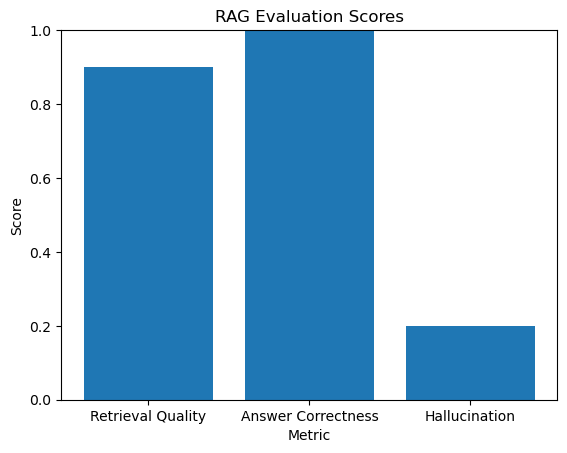

In [30]:
def plot_scores(scores):
    """
    Plot the evaluation scores.
    """
    labels = ["Retrieval Quality", "Answer Correctness", "Hallucination"]
    scores = [scores["retrieval_quality"], scores["answer_correctness"], scores["hallucination"]]
    
    _, ax = plt.subplots()
    ax.bar(labels, scores)
    ax.set_xlabel('Metric')
    # set y range to 0-1
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')
    ax.set_title('RAG Evaluation Scores')
    plt.show()

plot_scores(results["scores"])

#### Reflections 

The RAG setup worked pretty well. The system was able to find the right pieces of information most of the time, and the answers it generated were accurate and matched what we expected. 

20% of the answers added extra info that wasn’t actually in the source document suggesting that the model hallucinated a bit. That is however a general problem for LLMs so we took the model from the exercise as a benchmark and our model performed good enough to be happy with the results. 

Regarding the hyperparameters:
- We chose Fixed-sized chunking for its simplicity and relevance to the context, since the data we analyzed was a political speech.
- Semantic chunking could improve the results, but since our model was generalizing well enough, we decided not to over-complicate things.
- The chunk size had to be reduced from 1000 to 500, because the WatsonX embedding model has a token limit of 512 tokens.
- More generally, parameters like retriever, top-k size, or prompt structure could improve our model, but in this context, it would rather complicate things, which was not necessary.
- Using a simple prompt format worked fine, but more controlled prompting might reduce hallucination even more.